In [1]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns 


import matplotlib.cm as cm
import matplotlib.colors as mcolors

from mpl_toolkits.basemap import Basemap


# For converting the text file containing the quarry locations into a CSV file
import csv

# For computing the geographical distance between two points 
import math

# Scikit-learn imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Imbalanced-learn import
from imblearn.under_sampling import RandomUnderSampler

# Matplotlib import
import matplotlib.pyplot as plt

# Other imports
from datetime import datetime, timedelta
import h5py
from scipy import stats, signal
import obspy
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.fdsn import Client
from obspy.signal.filter import envelope
import tsfel
from joblib import dump, load
import time
import os
import sys
import pickle
from zenodo_get import zenodo_get

# Custom imports
sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
import seis_feature

sys.path.append('../src')

# TSFEL imports
from tsfel import time_series_features_extractor, get_features_by_domain

# Utils imports
from utils import apply_cosine_taper, butterworth_filter, plot_confusion_matrix, plot_classification_report, calculate_distance

# Reload the module
import importlib
import utils
importlib.reload(utils)
from utils import plot_confusion_matrix
from utils import plot_classification_report


# Set pandas display option
pd.set_option('display.max_columns', None)


In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import time


## Downloading the features

In [6]:
## specify a filename 
filename = 'P_10_30_F_1_10_50'

In [74]:
if filename == 'P_10_30_F_1_15_50':
    doi = '10.5281/zenodo.12747189'
    
elif filename == 'P_10_30_F_1_10_50':
    doi = '10.5281/zenodo.13294736'
    
elif filename == 'P_10_30_F_05_15_50':
    doi = '10.5281/zenodo.13294778'
    
    

    
elif filename == 'P_10_100_F_1_10_50':
    doi = '10.5281/zenodo.12747222'
    
elif filename == 'P_10_100_F_05_15_50':
    doi = '10.5281/zenodo.13294804'
    
    
elif filename == 'P_50_100_F_1_10_50':
    doi = '10.5281/zenodo.12747234'

elif filename == 'P_50_100_F_05_15_50':
    doi = '10.5281/zenodo.13294827'
    
## This is going to download all the feature files in current directory. Make sure we delete them after storing
files = zenodo_get([doi])

Title: Physical and Tsfel Features for (P_10_30_F_1_10_50)
Keywords: 
Publication date: 2024-08-11
DOI: 10.5281/zenodo.13294736
Total size: 1617.6 MB

Link: https://zenodo.org/record/13294736/files/tsfel_features_explosion_P_10_30_F_1_10_50_part_1.csv   size: 94.9 MB

Checksum is correct. (b27ba6d7178bc5d24166d344996f4eba)

Link: https://zenodo.org/record/13294736/files/tsfel_features_noise_P_10_30_F_1_10_50_part_1.csv   size: 307.5 MB

Checksum is correct. (debfe165d56bb1d9b47eb40b1b323728)

Link: https://zenodo.org/record/13294736/files/tsfel_features_earthquake_P_10_30_F_1_10_50_part_4.csv   size: 108.1 MB

Checksum is correct. (3b85af1b24993527cf836f90f19bf7e5)

Link: https://zenodo.org/record/13294736/files/physical_features_earthquake_P_10_30_F_1_10_50_part_1.csv   size: 34.8 MB

Checksum is correct. (5d1150e2cd79863b93bd4f462d7028bf)

Link: https://zenodo.org/record/13294736/files/tsfel_features_earthquake_P_10_30_F_1_10_50_part_3.csv   size: 295.1 MB

Checksum is correct. (bcd3

### Loading tsfel features

In [40]:
# These waveforms are filtered between 1-10 Hz
# extracting features of surface events, thunder and sonic booms
features_exotic_tsfel = pd.read_csv('tsfel_features_surface event_'+filename+'_part_1.csv')




# features of noise
features_noise_tsfel = pd.read_csv('tsfel_features_noise_'+filename+'_part_1.csv')



# features of explosion
features_explosion_tsfel = pd.read_csv('tsfel_features_explosion_'+filename+'_part_1.csv')



# features of earthquake (had to extract it in three parts because of memory constraints)
features_eq1 = pd.read_csv('tsfel_features_earthquake_'+filename+'_part_1.csv')
features_eq2 = pd.read_csv('tsfel_features_earthquake_'+filename+'_part_2.csv')
features_eq3 = pd.read_csv('tsfel_features_earthquake_'+filename+'_part_3.csv')
features_eq4 = pd.read_csv('tsfel_features_earthquake_'+filename+'_part_4.csv')



# features of earthquakes
features_earthquake_tsfel = pd.concat([features_eq1, features_eq2, features_eq3, features_eq4])

In [41]:
features_earthquake_tsfel.head()

,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,0_FFT mean coefficient_10,0_FFT mean coefficient_11,0_FFT mean coefficient_12,0_FFT mean coefficient_13,0_FFT mean coefficient_14,0_FFT mean coefficient_15,0_FFT mean coefficient_16,0_FFT mean coefficient_17,0_FFT mean coefficient_18,0_FFT mean coefficient_19,0_FFT mean coefficient_20,0_FFT mean coefficient_21,0_FFT mean coefficient_22,0_FFT mean coefficient_23,0_FFT mean coefficient_24,0_FFT mean coefficient_25,0_FFT mean coefficient_26,0_FFT mean coefficient_27,0_FFT mean coefficient_28,0_FFT mean coefficient_29,0_FFT mean coefficient_30,0_FFT mean coefficient_31,0_FFT mean coefficient_32,0_FFT mean coefficient_33,0_FFT mean coefficient_34,0_FFT mean coefficient_35,0_FFT mean coefficient_36,0_FFT mean coefficient_37,0_FFT mean coefficient_38,0_FFT mean coefficient_39,0_FFT mean coefficient_40,0_FFT mean coefficient_41,0_FFT mean coefficient_42,0_FFT mean coefficient_43,0_FFT mean coefficient_44,0_FFT mean coefficient_45,0_FFT mean coefficient_46,0_FFT mean coefficient_47,0_FFT mean coefficient_48,0_FFT mean coefficient_49,0_FFT mean coefficient_50,0_FFT mean coefficient_51,0_FFT mean coefficient_52,0_FFT mean coefficient_53,0_FFT mean coefficient_54,0_FFT mean coefficient_55,0_FFT mean coefficient_56,0_FFT mean coefficient_57,0_FFT mean coefficient_58,0_FFT mean coefficient_59,0_FFT mean coefficient_60,0_FFT mean coefficient_61,0_FFT mean coefficient_62,0_FFT mean coefficient_63,0_FFT mean coefficient_64,0_FFT mean coefficient_65,0_FFT mean coefficient_66,0_FFT mean coefficient_67,0_FFT mean coefficient_68,0_FFT mean coefficient_69,0_FFT mean coefficient_70,0_FFT mean coefficient_71,0_FFT mean coefficient_72,0_FFT mean coefficient_73,0_FFT mean coefficient_74,0_FFT mean coefficient_75,0_FFT mean coefficient_76,0_FFT mean coefficient_77,0_FFT mean coefficient_78,0_FFT mean coefficient_79,0_FFT mean coefficient_80,0_FFT mean coefficient_81,0_FFT mean coefficient_82,0_FFT mean coefficient_83,0_FFT mean coefficient_84,0_FFT mean coefficient_85,0_FFT mean coefficient_86,0_FFT mean coefficient_87,0_FFT mean coefficient_88,0_FFT mean coefficient_89,0_FFT mean coefficient_90,0_FFT mean coefficient_91,0_FFT mean coefficient_92,0_FFT mean coefficient_93,0_FFT mean coefficient_94,0_FFT mean coefficient_95,0_FFT mean coefficient_96,0_FFT mean coefficient_97,0_FFT mean coefficient_98,0_FFT mean coefficient_99,0_FFT mean coefficient_100,0_FFT mean coefficient_101,0_FFT mean coefficient_102,0_FFT mean coefficient_103,0_FFT mean coefficient_104,0_FFT mean coefficient_105,0_FFT mean coefficient_106,0_FFT mean coefficient_107,0_FFT mean coefficient_108,0_FFT mean coefficient_109,0_FFT mean coefficient_110,0_FFT mean coefficient_111,0_FFT mean coefficient_112,0_FFT mean coefficient_113,0_FFT mean coefficient_114,0_FFT mean coefficient_115,0_FFT mean coefficient_116,0_FFT mean coefficient_117,0_FFT mean coefficient_118,0_FFT mean coefficient_119,0_FFT mean coefficient_120,0_FFT mean coefficient_121,0_FFT mean coefficient_122,0_FFT mean coefficient_123,0_FFT mean coefficient_124,0_FFT mean coefficient_125,0_FFT mean coefficient_126,0_FFT mean coefficient_127,0_FFT mean coefficient_128,0_FFT mean coefficient_129,0_FFT mean coefficient_130,0_FFT mean coefficient_131,0_FFT mean coefficient_132,0_FFT mean coefficient_133,0_FFT mean coefficient_134,0_FFT mean coefficient_135,0_FFT mean coefficient_136,0_FFT mean coefficient_137,0_FFT mean coefficient_138,0_FFT mean coefficient_139,0_FFT mean coefficient_140,0_FFT mean coefficient_141,0_FFT mean coefficient_142,0_FFT mean coefficient_143,0_FFT mean coefficient_144,0_FFT mean coefficient_145,0_FFT mean coefficient_146,0_FFT mean coefficient_147,0_FFT mean coefficient_148,0_FFT mean coefficient_149,0_FFT mean coefficient_150,0_FFT mean coefficient_151,0_FFT

### Loading physical features

In [42]:
# extracting features of surface events, thunder and sonic booms
features_exotic_physical = pd.read_csv('physical_features_surface event_'+filename+'_part_1.csv')

features_surface_physical = features_exotic_physical[features_exotic_physical['source'] == 'surface event']
features_sonic_physical = features_exotic_physical[features_exotic_physical['source'] == 'sonic']
features_thunder_physical = features_exotic_physical[features_exotic_physical['source'] == 'thunder']



# features of noise
features_noise_physical = pd.read_csv('physical_features_noise_'+filename+'_part_1.csv')


# features of explosion
features_explosion_physical = pd.read_csv('physical_features_explosion_'+filename+'_part_1.csv')

# features of earthquakes
features_eq1 = pd.read_csv('physical_features_earthquake_'+filename+'_part_1.csv')
features_eq2 = pd.read_csv('physical_features_earthquake_'+filename+'_part_2.csv')
features_eq3 = pd.read_csv('physical_features_earthquake_'+filename+'_part_3.csv')
features_eq4 = pd.read_csv('physical_features_earthquake_'+filename+'_part_4.csv')

features_earthquake_physical = pd.concat([features_eq1, features_eq2, features_eq3, features_eq4])

In [43]:
features_earthquake_physical.head()

,Window_Length,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,RMSDecPhaseLine,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart1,Fquart3,NPeakFFT,MeanPeaksFFT,E1FFT,E2FFT,E3FFT,E4FFT,Gamma1,Gamma2,Gamma,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistMaxMedianFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Area,Envelope_Velocity,Envelope_Rise_Time,E_0.1_1,Kurto_0.1_1,E_1_3,Kurto_1_3,E_3_10,Kurto_3_10,E_10_20,Kurto_10_20,E_20_50,Kurto_20_50,serial_no,source
0,40.0,5.826687,26.935974,4.552778,15.272860,1.002468,-0.516148,1.496712,247,0.823406,-0.401014,-2.053310,1.058542,2.333113,17.180406,6.475,0.000070,0.000002,5.878181,3.992184,13.660723,5,2.784170,31.711345,25.892210,0.405142,0.001879,5.849793,6.203808,NaN,-0.445465,0.195954,21.178704,27216.100066,2,1,2,2.0,1.0,1,1,1.0,0.004100,0.004476,0.145017,-0.050857,0.094160,0.401457,0.068900,2.757138,0.068928,32.796398,-0.727221,1.696964,0.054818,6.766944,0.401503,14.099075,-0.375456,14.503052,0,0,0,earthquake
1,40.0,6.970794,40.852197,6.964143,21.436820,5.176772,-0.753978,2.384991,225,-1.324535,0.827263,-1.601105,2.097985,2.436224,23.351999,1.775,0.000050,0.000003,4.798430,3.511266,13.601711,4,2.499599,44.202249,16.117473,0.343612,0.002568,3.876524,4.381164,NaN,3.103105,-0.122630,14.442621,6538.927856,2,2,1,1.0,2.0,3,2,1.5,0.011102,0.011617,0.068941,-1.329274,-1.260334,0.528269,0.075783,3.032755,0.075819,34.977489,-0.848592,21.077544,0.254080,16.205996,0.386085,16.941848,-0.454022,11.311745,0,0,1,earthquake
2,40.0,3.747255,9.634860,2.287829,4.096323,-0.561901,-0.128545,0.831868,243,7.716826,-8.442224,-0.914075,0.947909,4.261457,61.753955,5.375,0.000056,0.000003,5.861640,4.200084,13.478774,1,5.748064,63.556073,41.960084,0.614507,0.003011,5.684375,5.970911,NaN,-1.368866,-0.146952,18.670583,6597.174552,2,2,1,1.0,2.0,2,1,2.0,0.026856,0.028316,0.642629,0.923926,1.566555,0.648430,0.173041,6.924936,0.173123,27.833917,-0.277491,0.360529,0.327439,3.001601,0.806271,4.300918,0.048525,4.880765,0,0,2,earthquake
3,40.0,4.079117,6.230912,1.316338,6.503730,0.187158,-0.291202,1.129641,227,5.844753,-7.776332,-0.751608,0.530759,3.911720,40.331023,2.075,0.000075,0.000003,5.240658,3.521060,13.577500,4,4.830992,62.143313,34.689583,0.692049,0.004147,4.434306,4.958858,NaN,-0.665459,1.811946,30.001754,31828.179171,2,2,1,1.0,2.0,1,2,0.5,0.018307,0.019561,2.178560,0.519336,2.697895,0.583711,0.143097,5.726623,0.143166,22.731366,-0.532398,3.804962,0.534737,5.618491,0.653298,6.800833,-0.129999,7.654449,0,0,3,earthquake
4,40.0,5.924179,19.123709,3.364629,13.622635,1.607061,0.453919,1.719132,169,4.468384,-4.040652,-1.105857,1.121379,3.027358,37.960630,2.750,0.000034,0.000003,4.813632,3.334355,13.348344,2,2.816064,53.062244,22.291783,0.230008,0.006028,3.906475,4.425901,NaN,-0.364767,1.584770,34.631485,30503.112952,1,2,2,0.5,0.5,1,1,1.0,0.015496,0.016260,-0.795493,0.423314,-0.372179,0.569545,0.096139,3.847349,0.096184,30.835418,-0.477656,9.928966,0.438774,14.756332,0.426552,13.627962,-0.319152,15.666304,0,0,4,earthquake


### removing the downloaded files to clean up the repository

In [72]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)


## Merging tsfel + physical features

In [44]:
features_noise = pd.merge(features_noise_physical, features_noise_tsfel, on = ['serial_no', 'source'])
features_earthquake = pd.merge(features_earthquake_physical, features_earthquake_tsfel, on = ['serial_no', 'source'])
features_explosion = pd.merge(features_explosion_physical, features_explosion_tsfel, on = ['serial_no', 'source'])


features_surface_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'surface event']
features_sonic_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'sonic']
features_thunder_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'thunder']

features_surface_physical = features_exotic_physical[features_exotic_physical['source'] == 'surface event']
features_sonic_physical = features_exotic_physical[features_exotic_physical['source'] == 'sonic']
features_thunder_physical = features_exotic_physical[features_exotic_physical['source'] == 'thunder']


features_surface = pd.merge(features_surface_physical, features_surface_tsfel, on = ['serial_no', 'source'])
features_sonic = pd.merge(features_sonic_physical, features_sonic_tsfel, on = ['serial_no', 'source'])
features_thunder = pd.merge(features_thunder_physical, features_thunder_tsfel, on = ['serial_no', 'source'])



features_all = pd.concat([features_surface, features_sonic, features_thunder, features_noise, features_explosion, features_earthquake])

In [45]:
features_all.head()

,Window_Length,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,RMSDecPhaseLine,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart1,Fquart3,NPeakFFT,MeanPeaksFFT,E1FFT,E2FFT,E3FFT,E4FFT,Gamma1,Gamma2,Gamma,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistMaxMedianFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Area,Envelope_Velocity,Envelope_Rise_Time,E_0.1_1,Kurto_0.1_1,E_1_3,Kurto_1_3,E_3_10,Kurto_3_10,E_10_20,Kurto_10_20,E_20_50,Kurto_20_50,serial_no,source,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,0_FFT mean coefficient_10,0_FFT mean coefficient_11,0_FFT mean coefficient_12,0_FFT mean coefficient_13,0_FFT mean coefficient_14,0_FFT mean coefficient_15,0_FFT mean coefficient_16,0_FFT mean coefficient_17,0_FFT mean coefficient_18,0_FFT mean coefficient_19,0_FFT mean coefficient_20,0_FFT mean coefficient_21,0_FFT mean coefficient_22,0_FFT mean coefficient_23,0_FFT mean coefficient_24,0_FFT mean coefficient_25,0_FFT mean coefficient_26,0_FFT mean coefficient_27,0_FFT mean coefficient_28,0_FFT mean coefficient_29,0_FFT mean coefficient_30,0_FFT mean coefficient_31,0_FFT mean coefficient_32,0_FFT mean coefficient_33,0_FFT mean coefficient_34,0_FFT mean coefficient_35,0_FFT mean coefficient_36,0_FFT mean coefficient_37,0_FFT mean coefficient_38,0_FFT mean coefficient_39,0_FFT mean coefficient_40,0_FFT mean coefficient_41,0_FFT mean coefficient_42,0_FFT mean coefficient_43,0_FFT mean coefficient_44,0_FFT mean coefficient_45,0_FFT mean coefficient_46,0_FFT mean coefficient_47,0_FFT mean coefficient_48,0_FFT mean coefficient_49,0_FFT mean coefficient_50,0_FFT mean coefficient_51,0_FFT mean coefficient_52,0_FFT mean coefficient_53,0_FFT mean coefficient_54,0_FFT mean coefficient_55,0_FFT mean coefficient_56,0_FFT mean coefficient_57,0_FFT mean coefficient_58,0_FFT mean coefficient_59,0_FFT mean coefficient_60,0_FFT mean coefficient_61,0_FFT mean coefficient_62,0_FFT mean coefficient_63,0_FFT mean coefficient_64,0_FFT mean coefficient_65,0_FFT mean coefficient_66,0_FFT mean coefficient_67,0_FFT mean coefficient_68,0_FFT mean coefficient_69,0_FFT mean coefficient_70,0_FFT mean coefficient_71,0_FFT mean coefficient_72,0_FFT mean coefficient_73,0_FFT mean coefficient_74,0_FFT mean coefficient_75,0_FFT mean coefficient_76,0_FFT mean coefficient_77,0_FFT mean coefficient_78,0_FFT mean coefficient_79,0_FFT mean coefficient_80,0_FFT mean coefficient_81,0_FFT mean coefficient_82,0_FFT mean coefficient_83,0_FFT mean coefficient_84,0_FFT mean coefficient_85,0_FFT mean coefficient_86,0_FFT mean coefficient_87,0_FFT mean coefficient_88,0_FFT mean coefficient_89,0_FFT mean coefficient_90,0_FFT mean coefficient_91,0_FFT mean coefficient_92,0_FFT mean coefficient_93,0_FFT mean coefficient_94,0_FFT mean coefficient_95,0_FFT mean coefficient_96,0_FFT mean coefficient_97,0_FFT mean coefficient_98,0_FFT mean coefficient_99,0_FFT mean coefficient_100,0_FFT mean coefficient_101,0_FFT mean coefficient_102,0_FFT mean coefficient_103,0_FFT mean coefficient_104,0_FFT mean coefficient_105,0_FFT mean coefficient_106,0_FFT mean coefficient_107,0_FFT mean coefficient_108,0_FFT mean coefficient_109,0_FFT mean coefficient_110,0_FFT mean coefficient_111,0_FFT mean coefficient_112,0_FFT mean coefficient_113,0_FFT mean coefficient_114,0_FFT mean coefficient_115,0_FFT mean coefficient_116,0_FFT mean coefficient_117,0_FFT mean coefficient_118,0_FFT mean coefficient_119,0_FFT mean coefficient_120,0_FFT mean coefficient_121,0_FFT mean coefficient_122,0_FFT mean coefficient_123,0_FFT mean coefficient_124,0_FFT

## Preprocessing the input features

### Removing highly correlated features

In [46]:
## visualising the correlated features and correlation coefficient
corr_matrix = features_all.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
correlated_features = [(column, row, upper.loc[row, column]) 
                               for column in upper.columns 
                               for row in upper.index 
                               if upper.loc[row, column] > 0.95]
correlated_df = pd.DataFrame(correlated_features, columns=['Feature 1', 'Feature 2', 'Correlation Coefficient'])

correlated_df

,Feature 1,Feature 2,Correlation Coefficient
0,RMSDecPhaseLine,AsDec,0.980025
1,MeanPeaksFFT,MeanFFT,0.961934
2,Gamma1,FCentroid,0.974275
3,Gamma2,FCentroid,0.984209
4,Gamma2,Gamma1,0.992134
...,...,...,...
409,0_Total energy,0_Standard deviation,0.983184
410,0_Total energy,0_Variance,1.000000
411,0_Total energy,0_Absolute energy,1.000000
412,0_Total energy,0_Area under the curve,0.978798


In [47]:
serial_nos = features_all['serial_no'].values
features_all = features_all.drop(['Unnamed: 0_x','Unnamed: 0_y', 'source_x', 'serial_no'], axis = 1, errors = 'ignore')
features_all.rename(columns={'source_y': 'source'}, inplace=True)


## extracting correlated features
columns_to_drop = np.unique(correlated_df['Feature 2'].values)

features_all.drop(columns = columns_to_drop, axis = 1,inplace=True)
features_all['serial_no'] = serial_nos
print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')

So we have 232991 events and each event have 349 features


### Dropping the columns with missing values and rows with infinity

In [48]:
# Identify columns with NaN values
nan_columns = features_all.columns[features_all.isnull().any()].tolist()
print("Columns with NaN values:", nan_columns)

# Identify columns with infinity values
inf_columns = features_all.columns[(features_all == np.inf).any() | (features_all == -np.inf).any()].tolist()
print("Columns with infinity values:", inf_columns)

# Dropping the columns that contain NaNs
features_all = features_all.dropna(axis=1)

# Dropping the rows that contain NaNs
features_all = features_all.dropna()

# Dropping all the rows containing infinity values
features_all = features_all.replace([np.inf, -np.inf], np.nan).dropna()

# Dropping sonic boom and thunder events
features_all = features_all[features_all['source'] != 'sonic']
features_all = features_all[features_all['source'] != 'thunder']

print(f'So we have {features_all.shape[0]} events and each event has {features_all.shape[1]} features')

Columns with NaN values: ['Gamma']
Columns with infinity values: ['RMSDecPhaseLine']
So we have 232982 events and each event has 348 features


### Removing features having same value for all the events

In [49]:
# Check unique values in each column
unique_counts = features_all.nunique()

# Identify columns with only one unique value (same value for all rows)
single_value_columns = unique_counts[unique_counts == 1].index.values

print(single_value_columns)

# Drop columns with the same value for all rows
features_all = features_all.drop(columns=single_value_columns)

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


['Window_Length' 'E_20_50' 'Kurto_20_50' '0_ECDF_0' '0_ECDF_1' '0_ECDF_2'
 '0_ECDF_3' '0_ECDF_4' '0_ECDF_5' '0_ECDF_6' '0_ECDF_7' '0_ECDF_8'
 '0_ECDF_9' '0_ECDF Percentile Count_0' '0_ECDF Percentile Count_1'
 '0_Entropy']
So we have 232982 events and each event have 332 features


### Removing the outliers based on z-score

In [50]:
df = features_all.drop(['serial_no', 'source'], axis = 1)
# Calculate Z-scores for each feature
z_scores = np.abs(stats.zscore(df))


# Define a threshold for Z-score beyond which data points are considered outliers
threshold = 10

# Filter out rows with any Z-score greater than the threshold
# Temporarily removing this 
outliers_removed_df =   features_all[(z_scores < threshold).all(axis=1)]

print(f'So we have {outliers_removed_df.shape[0]} events and each event have {outliers_removed_df.shape[1]} features')


So we have 216778 events and each event have 332 features


## Standardizing the features

In [51]:
# Define global variables X and y
X = outliers_removed_df.drop(columns=['serial_no', 'source'])
y = outliers_removed_df['source']

# Initialize and apply StandardScaler to the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Access the mean and standard deviation for each feature
scaler_params = pd.DataFrame({
    'Feature': X.columns,
    'Mean': scaler.mean_,
    'Std Dev': scaler.scale_
})

# Display the scaler parameters (optional: for review)
print(scaler_params)

# Add 'serial_no' and 'source' back to the scaled DataFrame
X_scaled['serial_no'] = outliers_removed_df['serial_no'].values
X_scaled['source'] = y.values


                  Feature          Mean       Std Dev
0             RappMaxMean  5.614405e+00  3.219974e+00
1           RappMaxMedian  1.556921e+01  3.764531e+01
2                KurtoEnv  6.309197e+00  6.287722e+00
3                 SkewEnv  1.864065e+00  1.516220e+00
4           CorPeakNumber  2.275182e+02  6.071164e+01
..                    ...           ...           ...
325     0_Signal distance  2.007544e+03  7.085426e+00
326               0_Slope -1.923428e-10  6.490529e-08
327   0_Sum absolute diff  1.021619e+02  6.207906e+01
328        0_Total energy  1.238965e+00  1.149217e+00
329  0_Zero crossing rate  3.665970e+02  8.630270e+01

[330 rows x 3 columns]


### For testing purpose

In [52]:
X_f = X_scaled.drop(columns = ['serial_no', 'source'])
y_f = X_scaled['source']

## Load and Preprocess data

In [100]:
# Apply random undersampling using imbalanced-learn
nos = 1000
rus = RandomUnderSampler(sampling_strategy={'earthquake': nos, 'explosion': nos, 'surface event': nos, 'noise': nos}, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_f, y_f)

# Convert categorical labels to numerical labels using LabelEncoder
y_resampled = LabelEncoder().fit_transform(y_resampled)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


## Grid search of the hyperparameters of each model

In [101]:
# Define hyperparameter grids for each model
mlp_param_grid = {'hidden_layer_sizes': [(100,), (200,), (300,)],
 'activation': ['relu', 'tanh'],
 'solver': ['adam'],
 'max_iter': [500]}
svc_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
knn_param_grid = {'n_neighbors': [3, 5, 7, 9]}
lr_param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear']}
rf_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]}
xgb_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7]}
lgbm_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7], 'num_leaves':[31]}



# Initialize GridSearchCV objects for each model
mlp_grid_search = GridSearchCV(MLPClassifier(), mlp_param_grid, cv=5, scoring='f1_micro')
svc_grid_search = GridSearchCV(SVC(), svc_param_grid, cv=5, scoring='f1_micro')
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring='f1_micro')
lr_grid_search = GridSearchCV(LogisticRegression(), logreg_param_grid, cv=5, scoring='f1_micro')
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='f1_micro')
xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_param_grid, cv=5, scoring='f1_micro')
lgbm_grid_search = GridSearchCV(LGBMClassifier(), lgbm_param_grid, cv=5, scoring='f1_micro')


# Define a list of GridSearchCV objects for iteration
grid_searches = [
    mlp_grid_search,
    svc_grid_search,
    knn_grid_search,
    lr_grid_search,
    rf_grid_search,
    xgb_grid_search,
    lgbm_grid_search
]

# Fit GridSearchCV objects to training data with progress bar
start_time = time.time()
for grid_search in tqdm(grid_searches, desc='Fitting models', unit='model'):
    grid_search.fit(X_train, y_train)
end_time = time.time()

# Print best hyperparameters for each model
print("MLP Best Parameters:", mlp_grid_search.best_params_)
print("SVC Best Parameters:", svc_grid_search.best_params_)
print("KNN Best Parameters:", knn_grid_search.best_params_)
print("LR Best Parameters:", lr_grid_search.best_params_)
print("RF Best Parameters:", rf_grid_search.best_params_)
print("XGB Best Parameters:", xgb_grid_search.best_params_)
print("LGBM Best Parameters:", lgbm_grid_search.best_params_)
print("Hyperparameter Tuning Time:", end_time - start_time, "seconds")


Fitting models:  43%|████▎     | 3/7 [03:05<03:00, 45.02s/model] /home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for altern

/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

Fitting models: 100%|██████████| 7/7 [1:37:48<00:00, 838.34s/model] 

MLP Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (300,), 'max_iter': 500, 'solver': 'adam'}
SVC Best Parameters: {'C': 10, 'kernel': 'rbf'}
KNN Best Parameters: {'n_neighbors': 7}
LR Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
RF Best Parameters: {'max_depth': None, 'n_estimators': 200}
XGB Best Parameters: {'max_depth': 3, 'n_estimators': 100}
LGBM Best Parameters: {'max_depth': 7, 'n_estimators': 100, 'num_leaves': 31}
Hyperparameter Tuning Time: 5868.3527319431305 seconds


## computing the accuracies and fitting times with the best hyperparameters for each model

In [102]:
# Initialize models with best hyperparameters
mlp_model = MLPClassifier(**mlp_grid_search.best_params_)
svc_model = SVC(**svc_grid_search.best_params_)
knn_model = KNeighborsClassifier(**knn_grid_search.best_params_)
rf_model = RandomForestClassifier(**rf_grid_search.best_params_)
xgb_model = XGBClassifier(**xgb_grid_search.best_params_)
lgbm_model = LGBMClassifier(**lgbm_grid_search.best_params_)
logreg_model = LogisticRegression(**logreg_grid_search.best_params_)

# Train models
start_time_mlp = time.time()
mlp_model.fit(X_train, y_train)
end_time_mlp = time.time()


start_time_svc = time.time()
svc_model.fit(X_train, y_train)
end_time_svc = time.time()


start_time_knn = time.time()
knn_model.fit(X_train, y_train)
end_time_knn = time.time()


start_time_rf = time.time()
rf_model.fit(X_train, y_train)
end_time_rf = time.time()


start_time_xgb = time.time()
xgb_model.fit(X_train, y_train)
end_time_xgb = time.time()




start_time_lgbm = time.time()
lgbm_model.fit(X_train, y_train)
end_time_lgbm = time.time()


start_time_logreg = time.time()
logreg_model.fit(X_train, y_train)
end_time_logreg = time.time()

# Evaluate models on testing set
mlp_preds = mlp_model.predict(X_test)
svc_preds = svc_model.predict(X_test)
knn_preds = knn_model.predict(X_test)
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
lgbm_preds = lgbm_model.predict(X_test)
logreg_preds = logreg_model.predict(X_test)

# Compute F1-scores for each model
mlp_f1 = f1_score(y_test, mlp_preds, average='micro')
svc_f1 = f1_score(y_test, svc_preds, average='micro')
knn_f1 = f1_score(y_test, knn_preds, average='micro')
rf_f1 = f1_score(y_test, rf_preds, average='micro')
xgb_f1 = f1_score(y_test, xgb_preds, average='micro')
lgbm_f1 = f1_score(y_test, lgbm_preds, average='micro')
logreg_f1 = f1_score(y_test, logreg_preds, average='micro')

# Print F1-scores and computational time for each model
print("MLP F1-score:", mlp_f1)
print("SVC F1-score:", svc_f1)
print("KNN F1-score:", knn_f1)
print("RF F1-score:", rf_f1)
print("XGB F1-score:", xgb_f1)
print("LGBM F1-score:", lgbm_f1)
print("LR F1-score:", logreg_f1)


print("Training Time (seconds):")
print("MLP:", end_time_mlp - start_time_mlp, "seconds")
print("SVC:", end_time_svc - start_time_svc, "seconds")
print("KNN:", end_time_knn - start_time_knn, "seconds")
print("RF:", end_time_rf - start_time_rf, "seconds")
print("XGB:", end_time_xgb - start_time_xgb, "seconds")
print("LGBM:", end_time_lgbm - start_time_lgbm, "seconds")
print("LogReg:", end_time_logreg - start_time_logreg, "seconds")

MLP F1-score: 0.8475
SVC F1-score: 0.84
KNN F1-score: 0.77375
RF F1-score: 0.85125
XGB F1-score: 0.88125
LGBM F1-score: 0.89
LR F1-score: 0.84875
Training Time (seconds):
MLP: 5.928471326828003 seconds
SVC: 0.8402941226959229 seconds
KNN: 0.002713441848754883 seconds
RF: 6.319203853607178 seconds
XGB: 41.518834590911865 seconds
LGBM: 98.13939571380615 seconds
LogReg: 0.1524064540863037 seconds


## Plotting the f1 score of each model

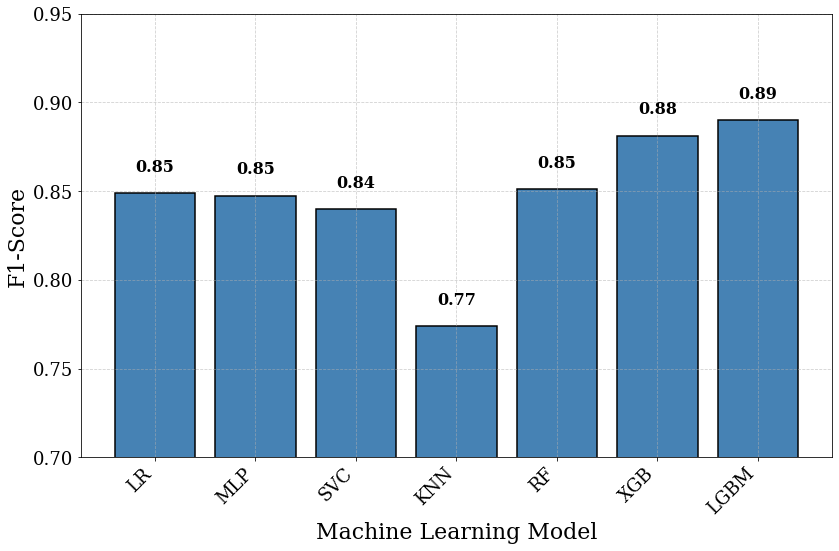

In [111]:
# Set rc parameters for publication-quality fonts and style
plt.rcParams.update({
    'font.family': 'serif',  # Use serif font for a more professional look
    'font.size': 18,         # Default font size for all elements
    'axes.labelsize': 22,    # Font size for axis labels
    'xtick.labelsize': 18,   # Font size for x-tick labels
    'ytick.labelsize': 18,   # Font size for y-tick labels
    'legend.fontsize': 18,   # Font size for legend text
    'figure.figsize': (12, 8),  # Larger figure size for better clarity
    'axes.grid': True,       # Enable grid for all plots
    'grid.alpha': 0.6,       # Slightly transparent grid
    'grid.linestyle': '--',  # Dotted grid lines
})

# Sample data (replace with your actual data)
values = [logreg_f1, mlp_f1, svc_f1, knn_f1, rf_f1, xgb_f1, lgbm_f1]
labels = ['LR','MLP', 'SVC', 'KNN', 'RF', 'XGB', 'LGBM']

# Create bar graph
fig, ax = plt.subplots()
bars = ax.bar(labels, values, color='#4682B4', edgecolor='black', linewidth=1.5)  # Sky blue color with black edges

# Add data labels above bars with slight offset
for bar, value in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}', 
            ha='center', va='bottom', fontsize=16, fontweight='bold')

# Set x-axis and y-axis labels with larger fonts
ax.set_xlabel('Machine Learning Model', fontsize=22)
ax.set_ylabel('F1-Score', fontsize=22)

# Customize the y-axis range for clarity
ax.set_ylim(0.7, 0.95)

# Add grid only on y-axis for a cleaner look
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

# Rotate x-axis labels slightly for better readability
plt.xticks(rotation=45, ha='right')

# Make layout tight to avoid overlap
plt.tight_layout()

# Save the figure for high-quality publication use
plt.savefig('../figures/f1_score_comparison.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


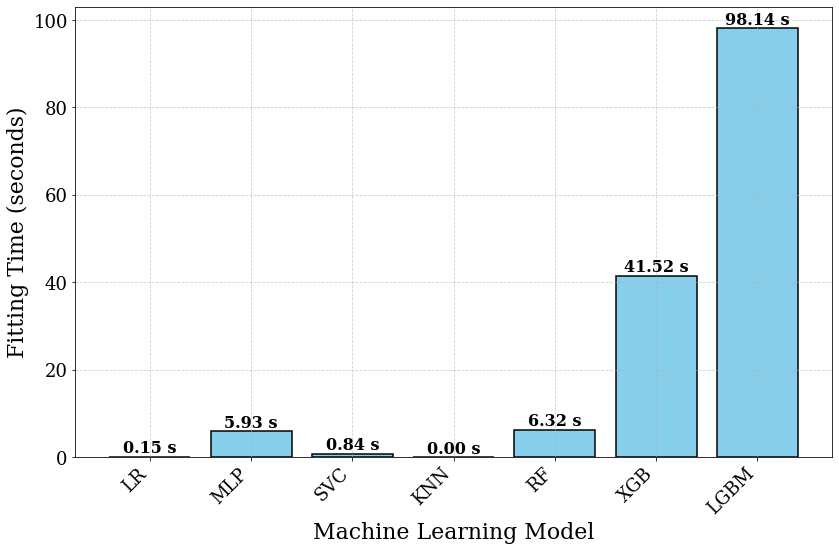

In [112]:
# Set rc parameters for a professional style
plt.rcParams.update({
    'font.family': 'serif',  # Use serif font for a more professional look
    'font.size': 18,         # Default font size for all elements
    'axes.labelsize': 22,    # Font size for axis labels
    'xtick.labelsize': 18,   # Font size for x-tick labels
    'ytick.labelsize': 18,   # Font size for y-tick labels
    'legend.fontsize': 18,   # Font size for legend text
    'figure.figsize': (12, 8),  # Larger figure size for better clarity
    'axes.grid': True,       # Enable grid for all plots
    'grid.alpha': 0.6,       # Slightly transparent grid
    'grid.linestyle': '--',  # Dotted grid lines
})

# Sample data (replace with your actual fitting times)
values = [end_time_logreg - start_time_logreg,
          end_time_mlp - start_time_mlp, 
          end_time_svc - start_time_svc, 
          end_time_knn - start_time_knn, 
          end_time_rf - start_time_rf, 
          end_time_xgb - start_time_xgb, 
          end_time_lgbm - start_time_lgbm]
labels = ['LR','MLP', 'SVC', 'KNN', 'RF', 'XGB', 'LGBM']

# Create bar graph
fig, ax = plt.subplots()
bars = ax.bar(labels, values, color='#87CEEB', edgecolor='black', linewidth=1.5)  # Sky blue color with black edges

# Add data labels above bars with slight offset
for bar, value in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f} s', 
            ha='center', va='bottom', fontsize=16, fontweight='bold')

# Set x-axis and y-axis labels with larger fonts
ax.set_xlabel('Machine Learning Model', fontsize=22)
ax.set_ylabel('Fitting Time (seconds)', fontsize=22)

# Add grid only on y-axis for a cleaner look
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

# Rotate x-axis labels slightly for better readability
plt.xticks(rotation=45, ha='right')

# Make layout tight to avoid overlap
plt.tight_layout()

# Save the figure for high-quality publication use
plt.savefig('../figures/fitting_time_comparison.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()
